## ARIMA

In [29]:
import pandas as pd
import datetime
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [30]:
import statsmodels.api as sm
from scipy import stats
from itertools import product
import warnings

In [53]:
heat = pd.read_csv("heat_energy.csv")
warnings.filterwarnings('default') 

In [32]:
heat.date = heat.date.apply(lambda x:datetime.datetime.strptime(x, '%m/%d/%Y'))

In [33]:
heat.index = heat['date']

In [34]:
heat.drop('date', axis='columns', inplace=True)

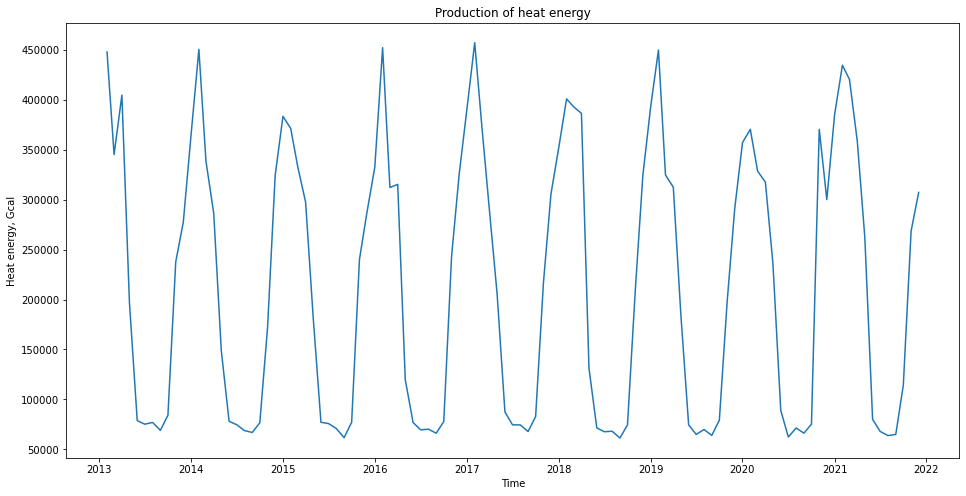

In [35]:
plt.figure(figsize=(16,8))
plt.title('Production of heat energy')
plt.xlabel('Time')
plt.ylabel('Heat energy, Gcal')
plt.plot(heat)
plt.show()

Критерий Дики-Фулера: p=0.742726


C:\Users\ALINA~1.KOR\AppData\Local\Temp/ipykernel_2468/239164406.py:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  sm.tsa.seasonal_decompose(heat,freq=12, model="multiplicative").plot()


<Figure size 1008x720 with 0 Axes>

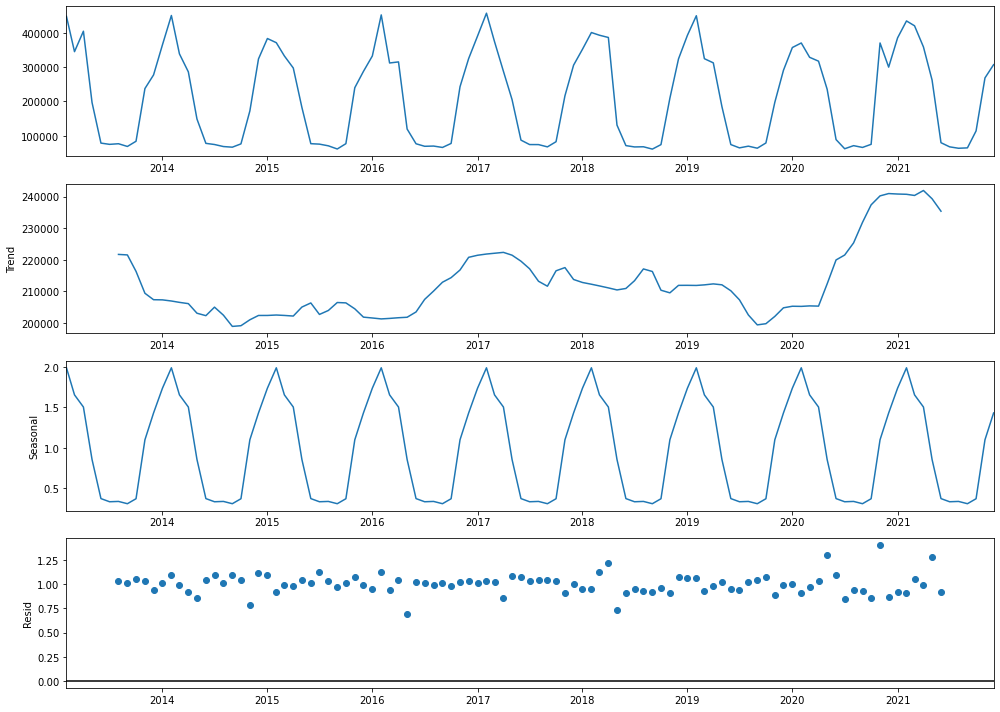

In [36]:
plt.figure(figsize(14,10))
sm.tsa.seasonal_decompose(heat,freq=12, model="multiplicative").plot()
#Проверка на стационарность
print ("Критерий Дики-Фулера: p=%f" % sm.tsa.stattools.adfuller(heat)[1])
warnings.filterwarnings("ignore")

Критерий Дики-Фулера: p=0.742726


<Figure size 1008x720 with 0 Axes>

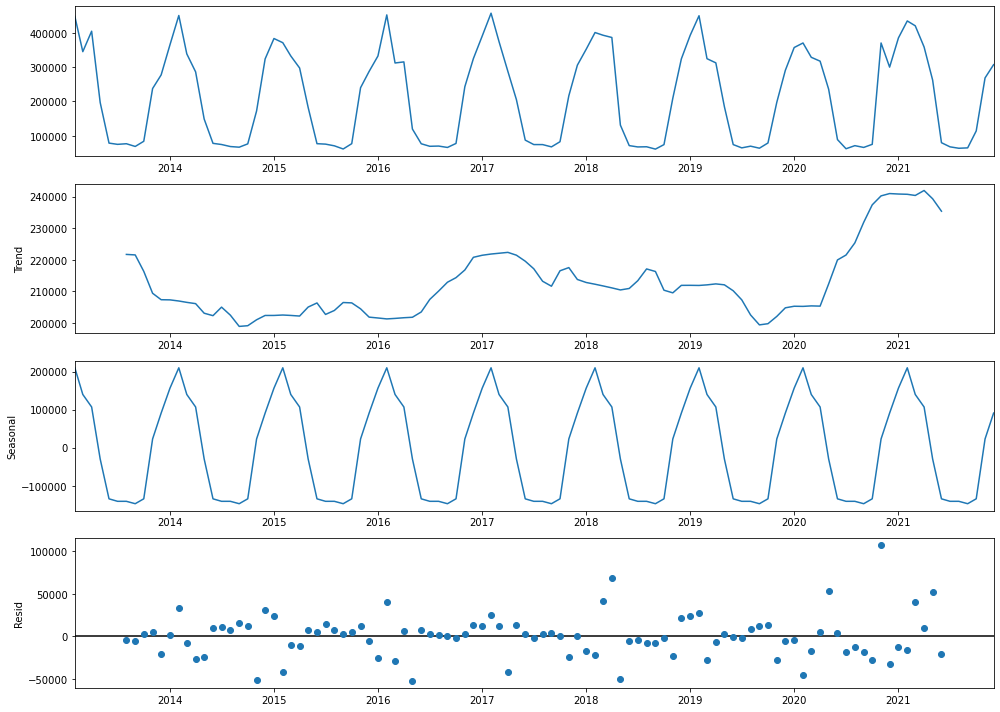

In [37]:
plt.figure(figsize(14,10))
sm.tsa.seasonal_decompose(heat,freq=12, model="additive").plot()
#Проверка на стационарность
print ("Критерий Дики-Фулера: p=%f" % sm.tsa.stattools.adfuller(heat)[1])

Оптимальный параметр преобразования Бокса-Кокса: 0.145213
Критерий Дики-Фуллера: p=0.834290


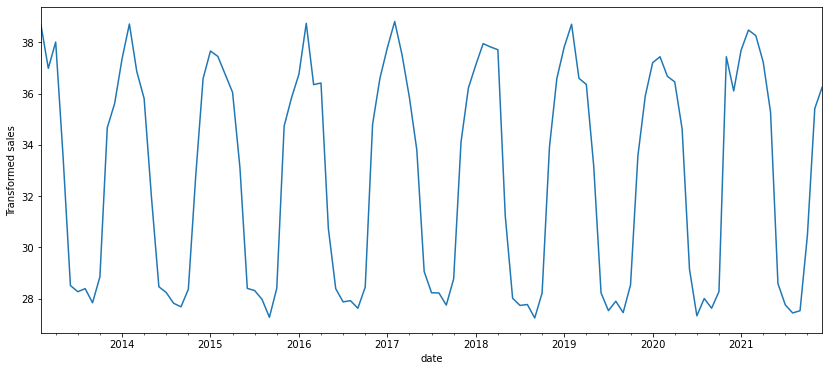

In [38]:
heat['heat_box'], lmbda = stats.boxcox(heat.value_gc)
plt.figure(figsize=(14,6))
heat.heat_box.plot()
plt.ylabel(u'Transformed sales')
print ("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller (heat.heat_box)[1])

Dickey-Fuller test: p=0.001453


<Figure size 720x504 with 0 Axes>

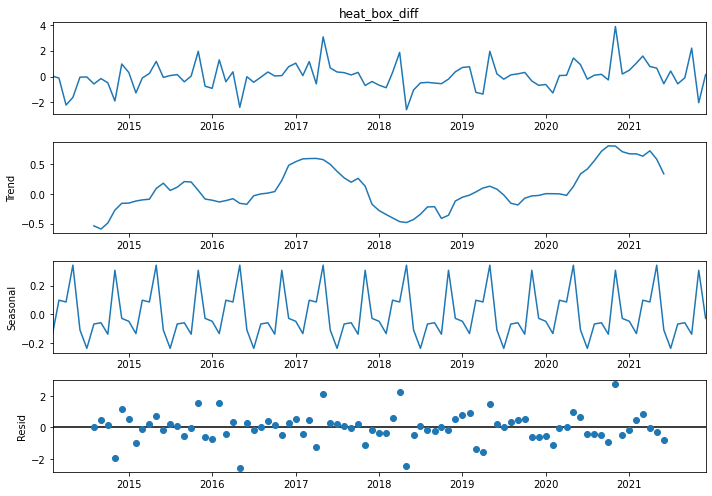

In [39]:
heat['heat_box_diff'] = heat.heat_box - heat.heat_box.shift(12)
plt.figure(figsize(10,7))
sm.tsa.seasonal_decompose(heat.heat_box_diff[12:]).plot()
print ("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller (heat.heat_box_diff[12:])[1])
pylab.show()

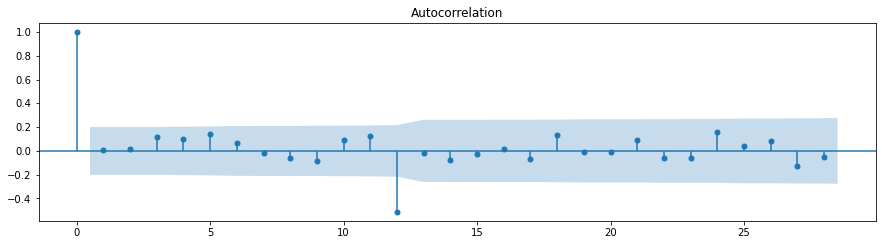

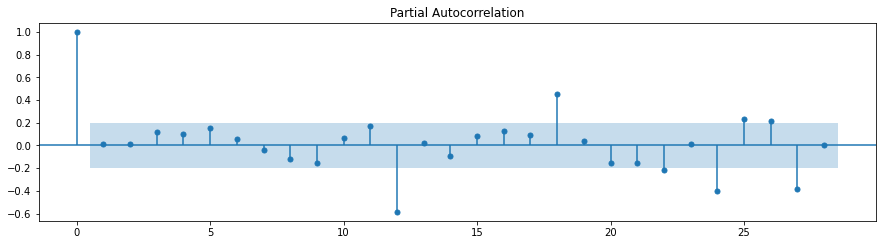

In [40]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(heat.heat_box_diff[12:].values.squeeze(), lags = 28, ax = ax )
pylab.show()
plt.figure(figsize=(15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(heat.heat_box_diff[12:].values.squeeze(), lags = 28, ax = ax )
pylab.show()

In [41]:
ps = range(0,4)
d=0
qs = range(0,2)
Ps = range(0,2)
D = 1
Qs = range(0,2)

In [42]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

32

In [43]:
heat.heat_box

date
2013-02-01    38.676587
2013-03-01    36.984887
2013-04-01    38.010726
2013-05-01    33.556098
2013-06-01    28.516336
                ...    
2021-08-01    27.446198
2021-09-01    27.534085
2021-10-01    30.476846
2021-11-01    35.417638
2021-12-01    36.250239
Name: heat_box, Length: 107, dtype: float64

In [44]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model = sm.tsa.statespace.SARIMAX(heat.heat_box, order = (param[0], d, param[1]), 
                                          seasonal_order = (param[2], D, param[3], 12)).fit(disp=-1) 
    
    except:
            print ('wrong parameters:', param)
            continue    
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])    
    
warnings.filterwarnings('default') 

In [45]:
result_table = pd.DataFrame(results)
result_table.columns=['parameters','aic']
print (result_table.sort_values(by='aic', ascending=[True]).head())
warnings.filterwarnings('ignore') 

      parameters         aic
15  (1, 1, 1, 1)  239.714824
13  (1, 1, 0, 1)  240.944780
1   (0, 0, 0, 1)  241.007047
11  (1, 0, 1, 1)  241.014641
3   (0, 0, 1, 1)  241.087216


In [46]:
print (best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           heat_box   No. Observations:                  107
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -114.857
Date:                            Tue, 31 May 2022   AIC                            239.715
Time:                                    10:23:58   BIC                            252.484
Sample:                                02-01-2013   HQIC                           244.875
                                     - 12-01-2021                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9335      0.121      7.731      0.000       0.697       1.170
ma.L1         -0.8231      0.170   

Критерий Стьюдента: p=0.851485
Критерий Дики-Фулера: p=0.000000


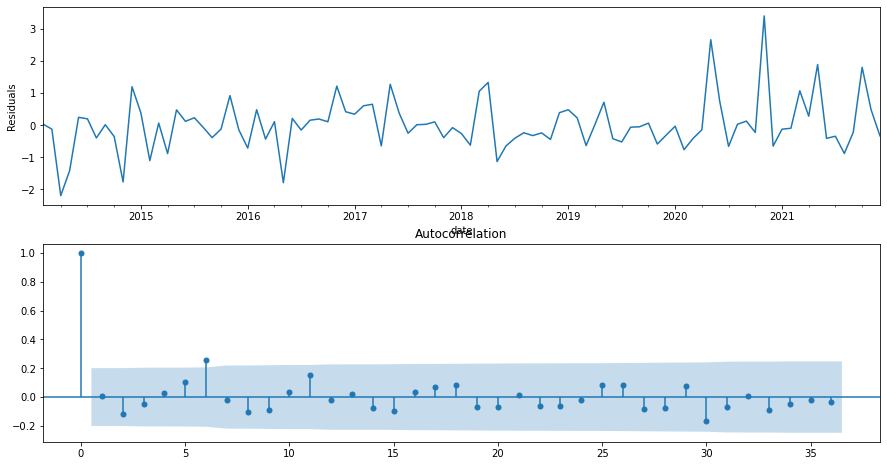

In [47]:
#Анализ остатков
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[12:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[12:].values.squeeze(), lags = 36, ax=ax)
print ("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[12:],0)[1])
print ("Критерий Дики-Фулера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1])
#Критерий Дики-Фулера уверенно отвергает гипотезу о нестационарности остатков, критерий стьюдента

In [48]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
    warnings.filterwarnings('default') 

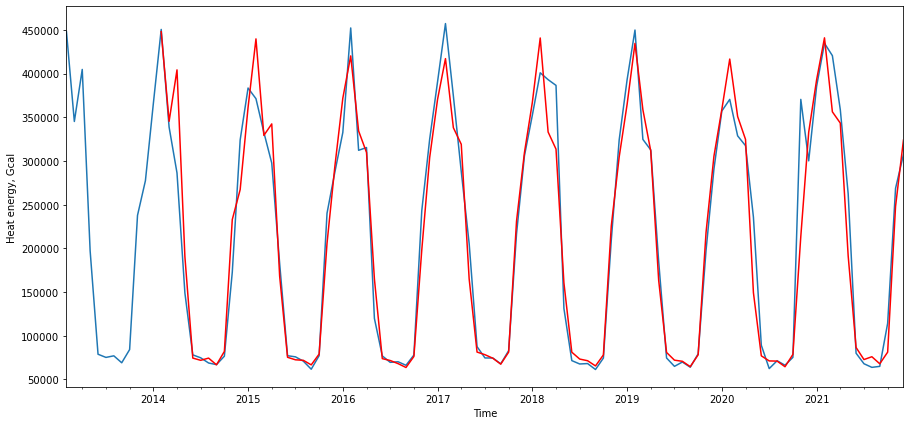

In [49]:
heat['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure (figsize(15,7))
heat.value_gc.plot()
heat.model[12:].plot(color='r')
plt.xlabel("Time")
plt.ylabel('Heat energy, Gcal')
pylab.show()

In [50]:
from datetime import datetime
heat2 = heat[['value_gc']]
date_list = [datetime.strptime('2022-01-01', '%Y-%m-%d') + relativedelta(months = x) for x in range(0,1)]
future = pd.DataFrame (index=date_list, columns = heat2.columns)
heat2 = pd.concat([heat2, future])
heat2['forecast'] = invboxcox(best_model.predict(start=71, end=72), lmbda)
warnings.filterwarnings('ignore') 

In [52]:
len()

,value_gc,heat_box,heat_box_diff,model
date,,,,
2013-02-01,447841,38.676587,NaN,1.000000
2013-03-01,345118,36.984887,NaN,1.000004
2013-04-01,404664,38.010726,NaN,1.000007
2013-05-01,197054,33.556098,NaN,1.000010
2013-06-01,78803,28.516336,NaN,1.000012
...,...,...,...,...
2021-08-01,63789,27.446198,-0.564168,75953.797341
2021-09-01,64922,27.534085,-0.096818,67879.335803
2021-10-01,114219,30.476846,2.197168,81197.268469


In [22]:
heat2[-12:]

,value_gc,forecast
2021-02-01,12524,NaN
2021-03-01,11000,NaN
2021-04-01,10200,NaN
2021-05-01,9085,NaN
2021-06-01,800,NaN
2021-07-01,680,NaN
2021-08-01,954,NaN
2021-09-01,954,NaN
2021-10-01,827,NaN
2021-11-01,4090,NaN


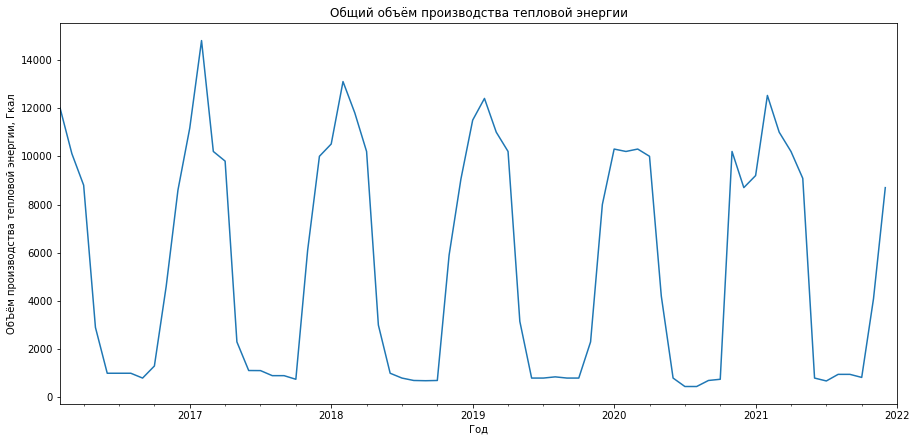

In [23]:
plt.figure(figsize(15,7))
heat2.value_gc.plot()
heat2.forecast.plot(color='r')
plt.title('Общий объём производства тепловой энергии')
plt.ylabel('ОбЪём производства тепловой энергии, Гкал')
plt.xlabel('Год')
pylab.show()

Оценка качества

In [24]:
heat_quality = heat[:-12]
warnings.filterwarnings('default') 

In [25]:
from datetime import datetime
heat_quality1 = heat_quality[['value_gc']]
date_list = [datetime.strptime('2021-01-01', '%Y-%m-%d') + relativedelta(months = x) for x in range(0,12)]
future = pd.DataFrame (index=date_list, columns = heat_quality1.columns)
heat_quality1 = pd.concat([heat_quality1, future])
heat_quality1['forecast'] = invboxcox(best_model.predict(start=59, end=71), lmbda)
warnings.filterwarnings('ignore')

In [75]:
real = heat[-12:][['value_gc']]

In [76]:
prognoz = heat_quality1[-12:][['forecast']]

In [77]:
real = real.loc[real.index != '2021-05-01']

In [78]:
prognoz = prognoz.loc[prognoz.index != ' 2021-05-01']

In [79]:
real['e'] = real['value_gc'] - prognoz['forecast']
real['p'] = 100*real['e']/real['value_gc']
print ('MAPE', np.mean(abs(real['p']))) #cредняя абсолютная ошибка нашего прогноза в процентах mean absolute percentage error
print ('MAE', np.mean(abs(real['e'])))

MAPE 9.472332216634204
MAE 402.9350309396584


In [32]:
real.to_excel('real.xlsx')

In [34]:
prognoz.to_excel('prognoz.xlsx')

Задаем процент отклонения. Если он превышает допустимый предел, тогда при обработке стат данных нужно обращать на это внимание.

In [35]:
real

,value_gc,e,p
date,,,
2021-01-01,9200,-1.806965e+03,-1.964092e+01
2021-02-01,12524,1.047850e+03,8.366733e+00
2021-03-01,11000,2.842964e+02,2.584512e+00
2021-04-01,10200,8.025259e+01,7.867901e-01
2021-05-01,9085,5.547570e+03,6.106296e+01
2021-06-01,800,9.094947e-13,1.136868e-13
2021-07-01,680,4.121054e+01,6.060374e+00
2021-08-01,954,2.908348e+02,3.048583e+01
2021-09-01,954,1.953346e+02,2.047533e+01


In [36]:
prognoz

,forecast
2021-01-01,11006.964514
2021-02-01,11476.150372
2021-03-01,10715.703650
2021-04-01,10119.747407
2021-05-01,3537.429754
2021-06-01,800.000000
2021-07-01,638.789455
2021-08-01,663.165226
2021-09-01,758.665394
2021-10-01,779.699558
